# FEATURE MATCHING

--> [OPENCV DOCUMENT](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

![featuredImage](https://docs.opencv.org/4.x/matcher_result1.jpg)

> **Notice how the image is not exactly what is shown in the secondary image (camera distortion, part of it is hidden)**

## What does it do?

1. Extracts defining key fetures from an input image (using ideas from corner, edge, contour detection)

2. Use distance calculation -> finds all the matches in a secondary image

=> No longer require an exact copy of the target image as in Template matching (which isn't really that helpful)

## METHODS we're using

* Brute-force Matching with ORB Descriptors
* Brute-force Matching with SIFT descriptors and Ratio test
* FLANN based Matcher

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img, cmap = "gray"):
    fig = plt.figure( figsize = (10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap ='gray')

In [3]:
reeses  = cv2.imread('DATA/reeses_puffs.png', 0)

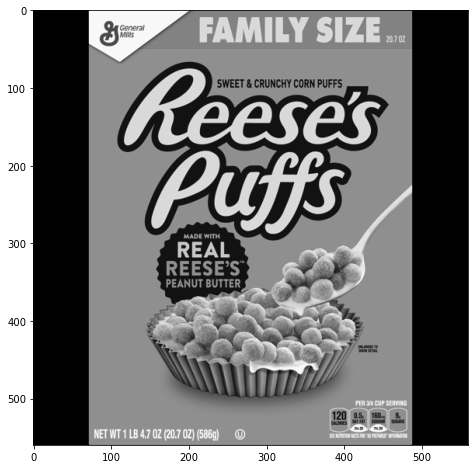

In [4]:
display(reeses)

In [5]:
cereals = cv2.imread('DATA/many_cereals.jpg' ,0)

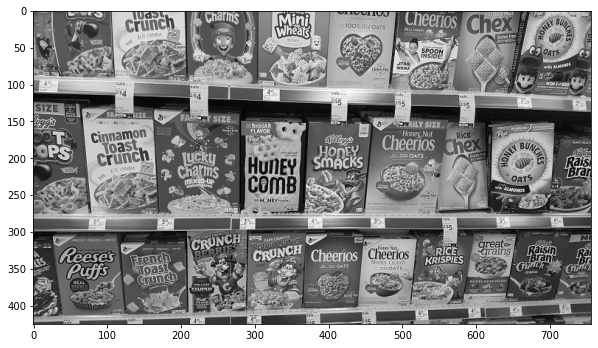

In [6]:
display(cereals)

# 1. ORB DESCRIPTOR

In [7]:
# CREATE DETECTOR
orb = cv2.ORB_create()

* **Finds the keypoints and descriptors with ORB:**


In [8]:
kp1, des1 =  orb.detectAndCompute(reeses, None)
kp2, des2 = orb.detectAndCompute(cereals, None)

* Creating a BFMatcher Object:

In [9]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)    #crossCheck boolean set to True = check back and forth => both directions => make sure two features in both sets match EACH OTHER => switching on CrossCheck <=> better result

In [10]:
matches = bf.match(des1 ,des2)

In [11]:
#matches       #returns a bunch of stuff

Taking a look at one of its stuff...

In [12]:
single_match = matches[0]

If you call it and type dot (.) + tab -> it returns 4 **attributes** : distance, ImgIdx, queryIdx, trainIdx

In [13]:
single_match.distance   

58.0

> **The smaller the distance == better match**

You can achieve the same result with a **for loop** but this is just a cleaner way:

In [14]:
matches = sorted(matches, key = lambda x:x.distance)  #Return a new list containing all items from the iterable in ascending orde

In [15]:
len(matches)

138

In [22]:
reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], None, flags =2) #slicing the matches because its length is up to 138 

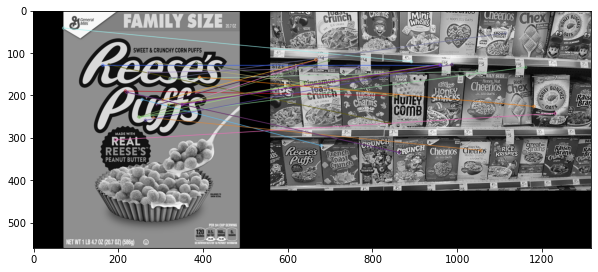

In [23]:
display(reeses_matches)

IT DOESN'T EVEN GET THE MATCH RIGHT!

We'll be fixing and improving this in the section below...

--------------

# 2. SIFT DESCRIPTOR 

--> **Great when dealing with images that has different scales to even begin with**

In [18]:
# CREATING A SIFT OBJECT

In [26]:
sift = cv2.SIFT_create()

In [27]:
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

In [28]:
bf = cv2.BFMatcher()

In [30]:
matches = bf.knnMatch(des1, des2, k=2)    # k best matches ('top 2 matches')

If you print out by typing 'matches, you'll notice that the output come in **pairs** in the same collumn. Where:
1st col = 1st best match
2nd col = 2nd best match
etc.

In [38]:
len(matches)

1501

In [35]:
# RATIO TEST... (since there're many 'candidates' in 'matches' output)

In [36]:
good = []

for match1, match2 in matches:
    
    # IF MATCH 1 < 75% MATCH 2 IN DIST => PROBABLY A GOOD MATCH
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

In [40]:
len(good)

79

In [42]:
sift_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags = 2)

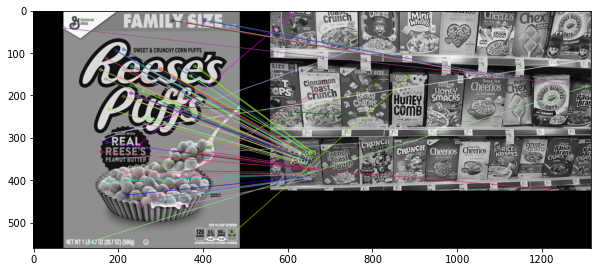

In [44]:
display(sift_matches)

Much better! It even matches the "Family Size" text to all the ones that have it !

> **SIFT descriptor is actually much the same as ORB, just with the addition of RATIO TEST!**

-----

# 3. FLANN Based Matcher (Approximate Near Neighbours)

* It's **much faster then Bruce-force method**
* Not going to find 'best' possible matches. Just generally good ones

=> Useful when detecting a **large number of images** bc it's fast

In [45]:
sift = cv2.SIFT_create()

In [46]:
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

In [47]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm= FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

In [48]:
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [50]:
matches = flann.knnMatch(des1,des2,k=2)

In [51]:
good = []

for match1, match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

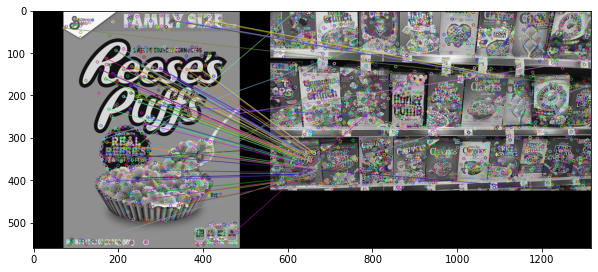

In [56]:
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags  =0)  # you can set flags = 0 or 2 and see it yourselves
display(flann_matches)

If you want to make spice things up, just put on a mask and change the color of the lines and separate it with the color of the points on the possible-but-not-so-great-matches

btw I copy the entire thing from OpenCV Doc, could not understand most of it at all bc hey I'm only in high school

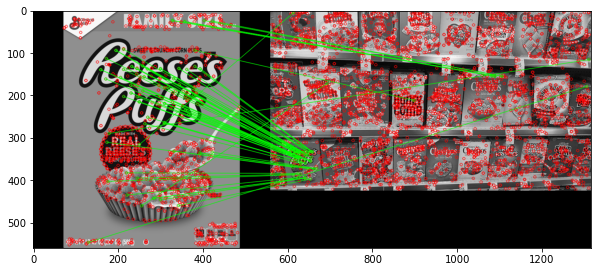

In [60]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses,None)
kp2, des2 = sift.detectAndCompute(cereals,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)


# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(reeses,kp1,cereals,kp2,matches,None,**draw_params)
display(img3)


noace